# HD Spam / Phishing / URL Detection — With Visualizations

This notebook auto-detects your CSV schemas (`sms_spam.csv`, `emails.csv`, `urls.csv`), cleans and merges them, trains/evaluates the HD models, and includes the requested visualizations:
- Distribution of email/message lengths (spam vs ham)
- Word clouds for spam and ham (optional; skipped if `wordcloud` isn't available)
- Histogram of keyword frequencies

## 0) Setup & Paths

In [ ]:
import os, re, json, warnings
warnings.filterwarnings("ignore")

import numpy as np # efficient numerical operations, arrays, matrices
import pandas as pd # handles dataframe, CSV reading/writing

from sklearn.model_selection import StratifiedKFold, cross_val_predict # splits data into folds for cross validation, 'cross_val_predict' generates prediction using cross validation
from sklearn.feature_extraction.text import TfidfVectorizer #converts text into TF-IDF features 
from sklearn.linear_model import LogisticRegression # classification for spam vs ham
from sklearn.svm import LinearSVC # support 
from sklearn.calibration import CalibratedClassifierCV # wraps classifiers to output probablities instead of just class labels
from sklearn.ensemble import RandomForestClassifier, IsolationForest #ensemble model for classification (collection of many decision to imporove accuracy and reduce errors)
from sklearn.cluster import KMeans # clustering algorithm
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    precision_recall_fscore_support, confusion_matrix
) # precision_recall_curve → plot precision/recall tradeoff.

#average_precision_score → summary score for PR curve.

# precision_recall_fscore_support → metrics for classification.

# confusion_matrix → summary of predictions vs actuals.

from urllib.parse import urlparse #splits URL components (domain,path,etc)
from scipy.sparse import hstack # Horizontally stacks sparse matrices (combine TF-IDF features with other features)
from joblib import dump # saves trained ML model to disk
from collections import Counter

# plotting (matplotlib only per requirement)
import matplotlib.pyplot as plt

# Locating CSV
DATA_DIR =  "." # fall back into current directory 
SMS_PATH    = os.path.join(DATA_DIR, "sms_spam.csv")
EMAILS_PATH = os.path.join(DATA_DIR, "emails.csv")
URLS_PATH   = os.path.join(DATA_DIR, "urls.csv")

# checks if folder has been created in current directory, if not it creates it
BASE_DIR = os.path.abspath("hd_project_viz")
RAW_DIR  = os.path.join(BASE_DIR, "data", "raw")
PROC_DIR = os.path.join(BASE_DIR, "data", "processed")
MODEL_DIR= os.path.join(BASE_DIR, "models")
for d in [RAW_DIR, PROC_DIR, MODEL_DIR]:
    os.makedirs(d, exist_ok=True)

print("Data dir:", DATA_DIR)
print("Project dir:", BASE_DIR)

Data dir: .
Project dir: c:\Users\Akhi\Desktop\New folder - Copy\hd_project_viz


## 1) Robust Loaders (auto-detect columns)

In [27]:
# Debugging check
def _inspect(name, df): #looks for dataset name("SMS, Emails" etc), df loads dataframe
    print(f"[{name}] columns:", list(df.columns)) #prints the column names
    return df.head(3) # shows first 3 rows

# defines a dictionary that maps text labels 0/1, 0- spam, 1- not spam
# 1 = spam/malicious, 0 = ham/benign
def _to_binary_labels(s):
    import pandas as pd

    # If already integer-like, just ensure int dtype
    if s.dtype.kind in "iu":
        return s.astype(int)

    # Normalize to lowercase strings
    s_norm = s.astype("string").str.strip().str.lower()

    # Words that mean "malicious" -> 1
    malicious = {"spam","malicious","phish","phishing","defacement","malware","bad","unsafe"}
    # Words that mean "benign" -> 0
    benign    = {"ham","benign","legit","legitimate","notspam","not_spam","good","safe","clean"}

    # Start as nullable Int
    out = pd.Series(pd.NA, index=s.index, dtype="Int64")

    # Map by vocabulary
    out = out.where(~s_norm.isin(malicious), 1)
    out = out.where(~s_norm.isin(benign), 0)

    # Try numeric strings like "0"/"1"
    num = pd.to_numeric(s_norm, errors="coerce").astype("Int64")
    out = out.fillna(num)

    return out  # drop NaNs or cast to int later


# read the sms dataset
def load_sms(path):
    df = pd.read_csv(path, encoding="latin-1") # using latin-1 because dataset has odd characters that uft-8 cannot read and may cause errors
    df.columns = [c.strip().lower() for c in df.columns] #converts all column names to lowercase 
    _inspect("SMS", df) #looking at column names in sms dataset

    if {"v1","v2"}.issubset(df.columns): # look for column v1 and v2
        df = df.rename(columns={"v1":"label","v2":"text"}) #rename them to text and label
        df["label"] = _to_binary_labels(df["label"]) #coverts label to binary
        out = df[["text","label"]].copy() #keep only text and label 
    else:
        text_candidates  = [c for c in ["text","message","sms","msg","content"] if c in df.columns] # otherwise use the common words to guess which column is text
        if not text_candidates: #if not text then use the below to verify if it is 
            str_cols = df.select_dtypes(include=["object"]).columns.tolist() # if none of the usual names match, then look for any column that contains text data
            if str_cols: text_candidates=[str_cols[0]]
        label_candidates = [c for c in ["label","category","spam","class","target"] if c in df.columns] #find likely column 
        if not (text_candidates and label_candidates): #if nothing fits, throw an error msg
            raise ValueError("SMS must have text + label-like column") 
        tcol, lcol = text_candidates[0], label_candidates[0] # assign tcol and lcol to array
        df["label"] = _to_binary_labels(df[lcol]) # convert label to binary
        out = df.rename(columns={tcol:"text"})[["text","label"]].copy() #standardize column names to text and label

    out = out.drop_duplicates(subset=["text"]).reset_index(drop=True) #drop dupolicate rows (delete them)
    out["source"] = "sms" #add a source column = "sms", any data from this data set will have sms in the source column
    return out # return final cleaned dataframe

def load_emails(path):
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    _inspect("EMAILS", df)

    if "text" in df.columns and "spam" in df.columns: #if dataset already has columns named text and spam, use them directly
        df["label"] = _to_binary_labels(df["spam"]) #covert spam column in 0 and 1, 
        out = df.rename(columns={"text":"text"})[["text","label"]].dropna() # keep text and label columns and remove any empty rows
    else: #if the dataset doesnt have text and spam rows
        text_candidates  = [c for c in ["text","email_text","body","message","content","subject_body"] if c in df.columns] #try to guess which column contains email text by using these keywords
        if not text_candidates: # if none of those names exist, pick the first column that contains text (not numbers)
            str_cols = df.select_dtypes(include=["object"]).columns.tolist()
            if str_cols: text_candidates=[str_cols[0]]
        label_candidates = [c for c in ["label","spam","is_phish","target","class"] if c in df.columns] # using these keyword, look for which column contains them (spam or not spam)
        if not (text_candidates and label_candidates): 
            raise ValueError("Emails must have text + label-like column")# if no text or label columns are found, show an error msg
        tcol, lcol = text_candidates[0], label_candidates[0] # choose the first match for text and label
        df["label"] = _to_binary_labels(df[lcol]) #convert label column into 0 and 1
        out = df.rename(columns={tcol:"text"})[["text","label"]].dropna() #rename the text column to "text", keep only the two columns, and remove empty rows.

    out["source"] = "phish" #in the source column, add phish so we knw its from this CSV
    return out

def load_urls(path):
    import pandas as pd
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    _inspect("URLS", df)

    # fast path for your file: has "url" and "type"
    if "url" in df.columns and "type" in df.columns:
        df = df.dropna(subset=["url", "type"])
        df["label"] = _to_binary_labels(df["type"])
        out = df.rename(columns={"url":"text"})[["text","label"]].dropna(subset=["text","label"])
    else:
        # generic fallback (same pattern as SMS/Emails)
        url_candidates = [c for c in ["url","link","website","address"] if c in df.columns]
        if not url_candidates:
            str_cols = df.select_dtypes(include=["object"]).columns.tolist()
            if str_cols: url_candidates = [str_cols[0]]
        label_candidates = [c for c in ["label","type","is_malicious","spam","target","class","malicious"] if c in df.columns]
        if not (url_candidates and label_candidates):
            raise ValueError("URLs must have a URL-like column and a label-like column")
        ucol, lcol = url_candidates[0], label_candidates[0]
        df = df.dropna(subset=[ucol, lcol])
        df["label"] = _to_binary_labels(df[lcol])
        out = df.rename(columns={ucol:"text"})[["text","label"]].dropna(subset=["text","label"])

    out = out.drop_duplicates(subset=["text"]).reset_index(drop=True)
    out["label"] = out["label"].astype(int)   # finalize as hard ints
    out["source"] = "url"
    return out



## 2) Load All Three & Preview

In [ ]:
sms_df   = load_sms(SMS_PATH) #loads sms csv from sms_path
email_df = load_emails(EMAILS_PATH) #loads email csv from emails_path
url_df   = load_urls(URLS_PATH) #loads urls csv from url_path

print("Loaded shapes:", sms_df.shape, email_df.shape, url_df.shape) #prints shape(rows,columns)
display(sms_df.head(3)); display(email_df.head(3)); display(url_df.head(3)) #display the 3 columns

[SMS] columns: ['v1', 'v2', 'unnamed: 2', 'unnamed: 3', 'unnamed: 4']
[EMAILS] columns: ['text', 'spam']
[URLS] columns: ['url', 'label']
Loaded shapes: (5169, 3) (5728, 3) (641119, 3)


,text,label,source
0,"Go until jurong point, crazy.. Available only ...",0,sms
1,Ok lar... Joking wif u oni...,0,sms
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,sms


,text,label,source
0,Subject: naturally irresistible your corporate...,1,phish
1,Subject: the stock trading gunslinger fanny i...,1,phish
2,Subject: unbelievable new homes made easy im ...,1,phish


,text,label,source
0,br-icloud.com.br,1,url
1,mp3raid.com/music/krizz_kaliko.html,0,url
2,bopsecrets.org/rexroth/cr/1.htm,0,url


## 3) Clean Each Dataset & Save Clean Copies

In [ ]:
def clean_text(s):
    s = str(s).lower().strip() #convert s to string, changes all to lowercase, removes extra space
    s = re.sub(r"[\r\n\t]+"," ", s) # replaces any newlines \n, tabs \t or carriage returns \r with a single space
    s = re.sub(r"\s+"," ", s) # replaces multiple spaces with just one space
    return s # returns clean text

# makes a copy of each dataset, applies function clean_text  to every value under the text column
sms_clean    = sms_df.copy();   sms_clean["text"]    = sms_clean["text"].map(clean_text) 
emails_clean = email_df.copy(); emails_clean["text"] = emails_clean["text"].map(clean_text)
urls_clean   = url_df.copy();   urls_clean["text"]   = urls_clean["text"].map(clean_text)

#save the clean copies to the folder
sms_clean.to_csv(os.path.join(PROC_DIR, "sms_clean.csv"), index=False)
emails_clean.to_csv(os.path.join(PROC_DIR, "emails_clean.csv"), index=False)
urls_clean.to_csv(os.path.join(PROC_DIR, "urls_clean.csv"), index=False)

print("Saved cleaned copies to:", PROC_DIR)

Saved cleaned copies to: c:\Users\Akhi\Desktop\New folder - Copy\hd_project_viz\data\processed


## 4) Merge → `data/processed/final.csv` (submission file)

In [ ]:
df = pd.concat([sms_clean, emails_clean, urls_clean], ignore_index=True) # joins (stacks) multiple DataFrames together into one big DataFrame, 
final_path = os.path.join(PROC_DIR, "final.csv") # creates path for where final.csv will be saved 
df.to_csv(final_path, index=False)  # saves merged dataframe as CSV without row numbers
print("Saved merged final:", final_path, "shape:", df.shape) #prints confirmation message
display(df.source.value_counts()) #display 

Saved merged final: c:\Users\Akhi\Desktop\New folder - Copy\hd_project_viz\data\processed\final.csv shape: (652016, 3)


source
url      641119
phish      5728
sms        5169
Name: count, dtype: int64

## 5) Evaluation Helpers

In [ ]:
def evaluate_probabilities(y_true, prob_pos, beta=2.0): # function to find best threshold for classification using precision recall meterics, y_true: actual labels, prob_pos: predicted probabilities, beta: weight for recall importance.
    precision, recall, thresholds = precision_recall_curve(y_true, prob_pos) # calculates precision, recall and threshold values across different cut-off points
    fbeta = (1+beta**2)*(precision*recall)/(beta**2*precision + recall + 1e-12) #computes the F-beta score (like F1 but with more weight on recall if beta>1), 1e-12 avoids divison by zero
    best_idx = int(np.nanargmax(fbeta)) # finds the position (index) of the highest F-beta score
    best_thr = float(thresholds[max(0, best_idx-1)]) if best_idx>0 else 0.5 #Gets the best threshold value for classification, if no valid threshold, default to 0.5
    return {
        "best_threshold": best_thr,
        "best_precision": float(precision[best_idx]),
        "best_recall": float(recall[best_idx]),
        "best_fbeta": float(fbeta[best_idx]),
        "pr_auc": float(average_precision_score(y_true, prob_pos))
    } # return dictionary with best threshold, precision, recall and F-beta score at that point 

def report_at_threshold(y_true, prob_pos, thr): # evaluate performance at specific threshold thr
    y_pred = (prob_pos >= thr).astype(int) #converts probabilities into class predictions 
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=[1]) #calculates precision, recall and f1 for the positive class (malicious/spam)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1]) #builds a confusion matrix showing true/false positives and negatives 
    return {
        "threshold": float(thr),
        "precision_malicious": float(p[0]),
        "recall_malicious": float(r[0]),
        "f1_malicious": float(f1[0]),
        "confusion_matrix[[TN,FP],[FN,TP]]": cm.tolist()
    } #returns a dictionary summarizing model performance at the chosen threshold: theshold, precision, recall, f1 score and confusion matrix

## 6) Text Models — TF‑IDF (word 1–2 + char 3–5) → LogReg & Calibrated Linear SVM (5‑fold CV)

In [ ]:
text_df = df[df["source"].isin(["sms","phish"])].reset_index(drop=True) # takes only the rows from dataframe where the source is SMS or phish,
X_text = text_df["text"].values #all messages text
y_text = text_df["label"].values #all labels(spam/ham or phish/legit)

tfidf_word = TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=1) # turns words into numerical features using TF-IDF, uses single words and 2-word phrases 
tfidf_char = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=1) # another TF-IDF but for character sequences (3-5 characteres), helps detect text pattern and misspellings
#fits both vectorizers to the text and converts the text into numerical matrices 
Xw = tfidf_word.fit_transform(X_text) # word based features
Xc = tfidf_char.fit_transform(X_text) # character based features
Xwc = hstack([Xw, Xc]) # combines both sets of features side by side into one big feature matrix 

#Create models 
logreg = LogisticRegression(max_iter=2000, class_weight="balanced") #builds a Logistric Regression model, max_iter=2000 gives it more time to converge, class_weight="balanced" helps handle uneven class sizes (spam vs ham)
svm_cal = CalibratedClassifierCV(LinearSVC(class_weight="balanced"), method="sigmoid", cv=3) # uses Linear SVM model wrapped in CalibratedClassifierCV to get probability output
#method= "sigmoid" converts SVM outputs to probabilities
#cv = 3 calibration done with 3 fold cross validation

def cv_probs(estimator, X, y, cv=5): # function that will return cross validated prediction probabilities 
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42) #set up 5 fold stratified cross validation (keeps class ratios balanced)
    out = np.zeros_like(y, dtype=float) #prepares an array to store probabilities for all samples
     
    for tr, te in skf.split(X, y): #loops thorugh each fold 
        est = estimator
        est.fit(X[tr], y[tr]) #trains on training data tr, predicts probabilities on test data te,
        out[te] = est.predict_proba(X[te])[:,1] # stores the "positive class" probability
    return out # returns all predicted probabilities 

# Get 5-fold cross validated probabilities for both models 
prob_log = cv_probs(logreg, Xwc, y_text, cv=5)
prob_svm = cv_probs(svm_cal, Xwc, y_text, cv=5)

#Finds the best  cut off threshold for each model 
best_log = evaluate_probabilities(y_text, prob_log, beta=2.0)
best_svm = evaluate_probabilities(y_text, prob_svm, beta=2.0)

#Evaluates each model's precision, recall, F1 and confusion matrix at its best threshold
rep_log  = report_at_threshold(y_text, prob_log, best_log["best_threshold"])
rep_svm  = report_at_threshold(y_text, prob_svm, best_svm["best_threshold"])

#print results
print("=== Text: Logistic Regression ===")
print(json.dumps(best_log, indent=2)); print(json.dumps(rep_log, indent=2))
print("=== Text: Linear SVM (Calibrated) ===")
print(json.dumps(best_svm, indent=2)); print(json.dumps(rep_svm, indent=2))

=== Text: Logistic Regression ===
{
  "best_threshold": 0.359285337676509,
  "best_precision": 0.9061205706396687,
  "best_recall": 0.9742701632855022,
  "best_fbeta": 0.9598323096419867,
  "pr_auc": 0.9888660215972699
}
{
  "threshold": 0.359285337676509,
  "precision_malicious": 0.905703771849126,
  "recall_malicious": 0.9742701632855022,
  "f1_malicious": 0.9387365911799762,
  "confusion_matrix[[TN,FP],[FN,TP]]": [
    [
      8671,
      205
    ],
    [
      52,
      1969
    ]
  ]
}
=== Text: Linear SVM (Calibrated) ===
{
  "best_threshold": 0.3393312286861148,
  "best_precision": 0.9298910468972051,
  "best_recall": 0.971301335972291,
  "best_fbeta": 0.9627268268757144,
  "pr_auc": 0.98714498189741
}
{
  "threshold": 0.3393312286861148,
  "precision_malicious": 0.9294507575757576,
  "recall_malicious": 0.971301335972291,
  "f1_malicious": 0.9499153157512703,
  "confusion_matrix[[TN,FP],[FN,TP]]": [
    [
      8727,
      149
    ],
    [
      58,
      1963
    ]
  ]
}


## 7) URL Model — RandomForest on engineered lexical features (5‑fold CV)

In [ ]:
# --- SPEEDY + ROBUST URL FEATURE PIPELINE ---
 

# ========= helpers (fast + numerically safe) =========

_IP_RE   = re.compile(r"\b\d{1,3}(?:\.\d{1,3}){3}\b")   # correct raw IP pattern
_SPECIAL = set("!@#$%^&*()_+=[]{}|;:'\\\",<>?/")       # O(1) membership

def shannon_entropy(s: str) -> float: #function to measure entropy - how random or complex a string is 
    """O(n) entropy using Counter (no quadratic s.count)."""
    if not s: # if string is empy, return 0
        return 0.0
    cnts = np.fromiter(Counter(s).values(), dtype=float) # counts how many times each character appears and stores those counts in a NumPy array
    p = cnts / cnts.sum() # converts count to probabilities
    return float(-(p * np.log2(p + 1e-12)).sum()) # caclulates Shannon entropy formula

def url_features(u: str) -> dict: #function that takes one URL and returns a set of numerical features 
    """Efficient, robust URL feature extractor."""
    try: # tries to split URL into parts (host, path and query string)
        p = urlparse(u)
        host  = p.netloc or ""
        path  = p.path  or ""
        query = p.query or ""
        pathq = path + (("?" + query) if query else "")
        full  = host + path + query
    except Exception: # If URL splitting fails, convert to a simple string to avoid crashing
        host = ""
        pathq = ""
        full = str(u or "")

    # one pass over the raw string u
    digits = specials = dots = dashes = 0 #initialize to 0
    for ch in u: #loop through each character and count, numbers, special symbol, dots and dashes 
        if ch.isdigit(): digits += 1
        if ch in _SPECIAL: specials += 1
        if ch == ".": dots += 1
        if ch == "-": dashes += 1

    return {                        #return a dictionary of URL features, length of URL etc
        "len":            len(u),
        "dots":           dots,
        "dashes":         dashes,
        "digits":         digits,
        "specials":       specials,
        "entropy":        shannon_entropy(full),
        "num_subdomains": host.count("."),
        "has_ip":         int(bool(_IP_RE.search(host))),
        "tld_len":        (len(host.split(".")[-1]) if "." in host else 0),
        "path_len":       len(pathq),
    } 

def evaluate_probabilities(y_true, prob, beta=2.0): # finds the best classification threshold based on precision and recall
    #computes precision,recall and thresholds for the model plus overall PR-AUC
    pr, rc, thr = precision_recall_curve(y_true, prob)
    ap = average_precision_score(y_true, prob)
    # precision_recall_curve gives len(thr) = len(pr)-1
    p = pr[:-1]; r = rc[:-1] #calculates the F-beta score for each threshold (recall weighted by beta)
    beta2 = beta**2
    fbeta = (1 + beta2) * (p * r) / np.clip(beta2 * p + r, 1e-12, None) #beta=2 means recall is twice important 
    best_idx = int(np.nanargmax(fbeta))
    return {             #returns the best threshold and corresponding precision,recall,F-beta and PR-AUC
        "best_threshold": float(thr[best_idx]),
        "best_precision": float(p[best_idx]),
        "best_recall":    float(r[best_idx]),
        f"best_f{beta:g}": float(fbeta[best_idx]),
        "pr_auc":         float(ap),
    }

def report_at_threshold(y_true, prob, threshold): #evaluates model performance at a chosen threshold 
    pred = (prob >= threshold).astype(int) #converts probabilities to 0/1 predictions (malicious vs safe)
    prec, rec, f1, _ = precision_recall_fscore_support(
        y_true, pred, average="binary", zero_division=0
    ) #computes precision, recall and F1 score
    cm = confusion_matrix(y_true, pred).tolist() #builds a confusion matrix(TP,TN,FP,FN counts)
    return {
        "threshold": float(threshold),
        "precision": float(prec),
        "recall":    float(rec),
        "f1":        float(f1),
        "confusion_matrix": cm,
    } #returns all the above metrics in a dictionary

# ========= build features =========
# expects df with columns: text, label, source
url_only = df[df["source"] == "url"].reset_index(drop=True) # takes only rows where the data source is UURL and resets the row index 

# To avoid bottlenecking on 600k+ rows, use a stratified subsample (keeps class balance).
# Remove this cap if you want the full set (will be slow).
MAX_URL_SAMPLES = 50000
if len(url_only) > MAX_URL_SAMPLES:
    frac = MAX_URL_SAMPLES / len(url_only)
    url_only = (url_only.groupby("label", group_keys=False)
                .apply(lambda g: g.sample(frac=frac, random_state=42))
                .reset_index(drop=True)) # if there are more than 50,000 URLs, keep a random balanced subnet per class to save time,ensure both classes (malicious/safe) stay proportinate

X_url = pd.DataFrame([url_features(u) for u in url_only["text"].tolist()]) #applies URL feature to every URL, making A DataFrame of Numeric features 
y_url = url_only["label"].to_numpy() # converts label to a NumPy array (0= benign, 1 = malicious )

# ========= model (bounded-depth RF; balanced; 5-fold CV) =========
rf = RandomForestClassifier(
    n_estimators=200,        # fewer trees than 400 for speed
    max_depth=20,            # cap depth to prevent CPU blowup
    min_samples_leaf=2,      # small regularization, faster trees
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
) # Creates a random Forest classifier with 200 trees(faster), depth limit = 20 (prevents overfitting/CPU strain), balanced class weights and uses all CPU cores 

#5-fold cross validation, setus up 5 fold cross validation and an empty array to store predictions
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
oof_rf = np.zeros(len(y_url), dtype=float)

for i, (tr, te) in enumerate(skf.split(X_url, y_url), 1): # for each fold, train on training set(tr),predict probabilities on test set(te), store positivies class probabilities and print progress after each fold
    rf.fit(X_url.iloc[tr], y_url[tr])
    oof_rf[te] = rf.predict_proba(X_url.iloc[te])[:, 1]
    print(f"[URL RF] Fold {i}/5 complete.") 

# ========= evaluation =========
#finds the best threshold and calculates precision,recall, F1 and confusion matrix 
best_rf = evaluate_probabilities(y_url, oof_rf, beta=2.0)
rep_rf  = report_at_threshold(y_url, oof_rf, best_rf["best_threshold"])

print("=== URL: RandomForest (URL features) ===")
print(json.dumps(best_rf, indent=2))
print(json.dumps(rep_rf,  indent=2))


[URL RF] Fold 1/5 complete.
[URL RF] Fold 2/5 complete.
[URL RF] Fold 3/5 complete.
[URL RF] Fold 4/5 complete.
[URL RF] Fold 5/5 complete.
=== URL: RandomForest (URL features) ===
{
  "best_threshold": 0.2566855335467421,
  "best_precision": 0.8015239848624323,
  "best_recall": 0.9433042431537767,
  "best_f2": 0.9110726160857534,
  "pr_auc": 0.9665892044256139
}
{
  "threshold": 0.2566855335467421,
  "precision": 0.8015239848624323,
  "recall": 0.9433042431537767,
  "f1": 0.8666537642732727,
  "confusion_matrix": [
    [
      29504,
      3881
    ],
    [
      942,
      15673
    ]
  ]
}


## 8) Visualizations

### 8.1 Distribution of message/email lengths (spam vs ham)

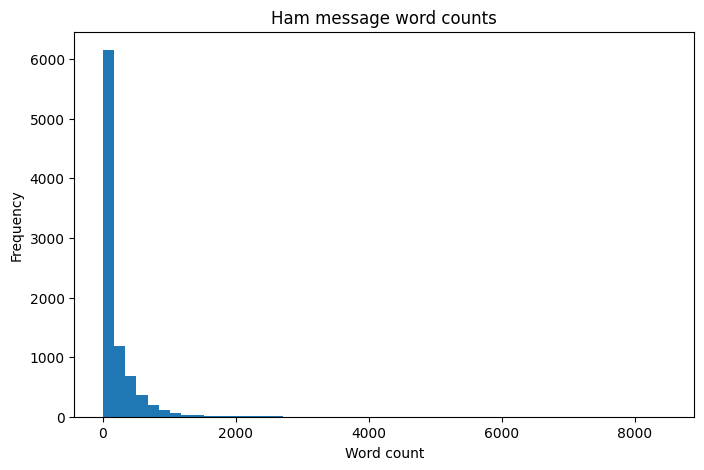

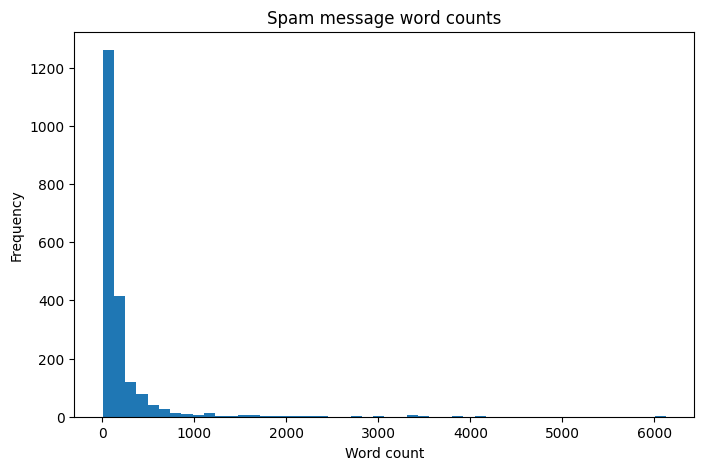

In [ ]:
# Use union of SMS + Emails (text datasets)
text_all = pd.concat([sms_clean, emails_clean], ignore_index=True) # joins the two cleaned datasets (sms and email) into a big dataframe called text_all
text_all["word_count"] = text_all["text"].apply(lambda x: len(str(x).split())) # add new column called word_count, for every message in text column, convert it to string, splits it into words and count how many words there are 

# Separate plots per class (matplotlib, one chart per plot)
#makes histogram to show ham message word counter
fig = plt.figure(figsize=(8,5))
plt.hist(text_all[text_all["label"]==0]["word_count"], bins=50) # splits range into into 50 bars, label chart
plt.title("Ham message word counts")
plt.xlabel("Word count"); plt.ylabel("Frequency")
plt.show() #display the plot 

#same as above but for spam
fig = plt.figure(figsize=(8,5))
plt.hist(text_all[text_all["label"]==1]["word_count"], bins=50)
plt.title("Spam message word counts")
plt.xlabel("Word count"); plt.ylabel("Frequency")
plt.show()

### 8.2 Word clouds for spam and ham (optional)

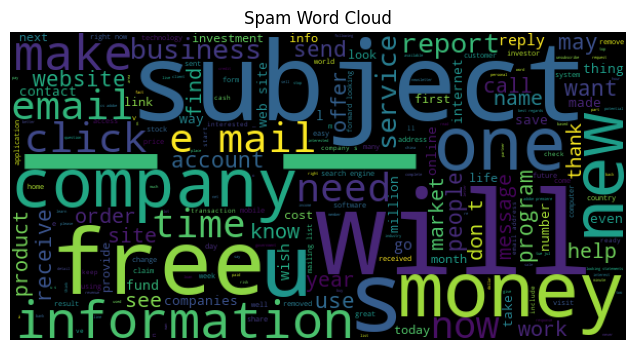

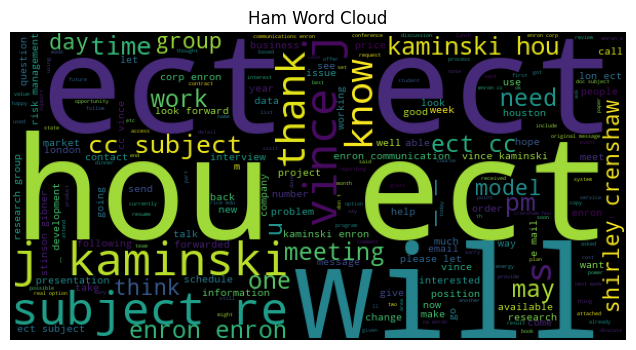

In [ ]:
# WordCloud is optional (skip if not installed)
try:
    from wordcloud import WordCloud

    #joins all the spam and ham messages into two big strings
    spam_words = " ".join(text_all[text_all["label"]==1]["text"]) 
    ham_words  = " ".join(text_all[text_all["label"]==0]["text"])

    # makes a word cloud image for the spam messages 
    plt.figure(figsize=(10,4))
    plt.imshow(WordCloud(width=600, height=300).generate(spam_words)) # shows the image, builds a cloud for all spam words
    plt.axis("off"); plt.title("Spam Word Cloud")# hides x/y axes
    plt.show() # displays image

    
# same thing but for ham words
    plt.figure(figsize=(10,4))
    plt.imshow(WordCloud(width=600, height=300).generate(ham_words))
    plt.axis("off"); plt.title("Ham Word Cloud")
    plt.show()
except Exception as e: 
    print("[WordCloud skipped]", e)

### 8.3 Histogram of keyword frequencies (spam vs ham)

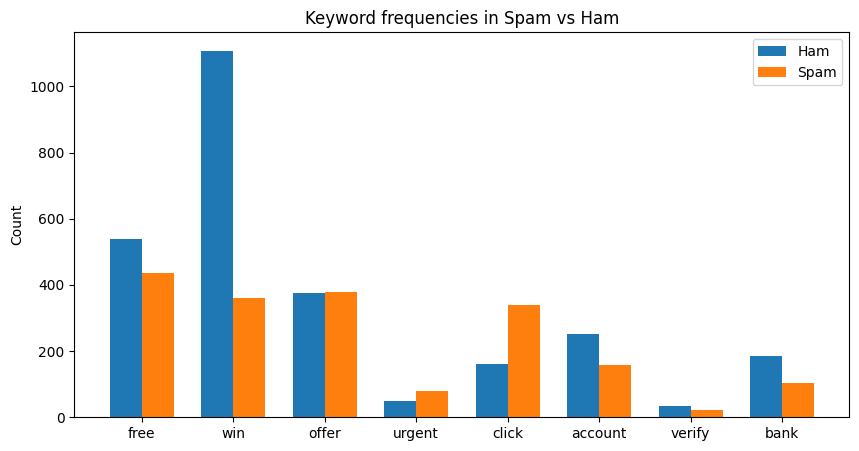

In [ ]:
keywords = ["free","win","offer","urgent","click","account","verify","bank"] # list of words found in spam msgs
ham_counts  = [] # store how many times ham words are counted
spam_counts = [] # store how many times spam words are counted

for k in keywords: #loops through each word in keyword list 
    ham_counts.append(int(text_all[text_all["label"]==0]["text"].str.contains(k, case=False, na=False).sum())) #select ham messages, checks if the message contain keywords, counts it, converts it to integer and adds to the counter
    spam_counts.append(int(text_all[text_all["label"]==1]["text"].str.contains(k, case=False, na=False).sum())) # Same thing but for spam

x = np.arange(len(keywords)) #creates array posotion for each word
width = 0.35 #width for each bar

plt.figure(figsize=(10,5))
plt.bar(x - width/2, ham_counts, width, label="Ham")
plt.bar(x + width/2, spam_counts, width, label="Spam")
plt.xticks(x, keywords)
plt.ylabel("Count")
plt.title("Keyword frequencies in Spam vs Ham")
plt.legend()
plt.show()

## 9) Extra 1 — K‑Means (themes)

In [37]:
if len(text_df) >= 6:
    tfidf_clu = TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=1)
    Xc2 = tfidf_clu.fit_transform(text_df["text"].values)
    k = min(6, max(2, int(np.sqrt(len(text_df))//2)))
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(Xc2)
    terms = np.array(tfidf_clu.get_feature_names_out())
    order = km.cluster_centers_.argsort()[:, ::-1]
    cluster_top_terms = {i: terms[order[i,:10]].tolist() for i in range(k)}
    print("Top terms per cluster:")
    for i in range(k):
        print(i, ":", cluster_top_terms[i])
else:
    print("[K-Means skipped] Not enough text rows.")

Top terms per cluster:
0 : ['gt', 'lt', 'lt gt', 'gt min', 'decimal gt', 'lt decimal', 'decimal', 'like lt', 'min', 'you']
1 : ['ect', 'ect ect', 'hou', 'hou ect', 'to', 'enron', 'the', 'vince', 'vince kaminski', '2000']
2 : ['to', 'the', 'is', 'and', 'in', 'for', 'you', 'your', 'it', 'ok']
3 : ['the', 'to', 'and', 'of', 'in', 'you', 'for', 'is', 'your', 'this']
4 : ['to', 'the', 'enron', 'vince', 'you', 'and', 'on', 'com', 'of', 'for']
5 : ['you', 'to', 'are you', 'are', 'your', 'do', 'the', 'when', 'me', 'and']


## 10) Extra 2 — IsolationForest (benign-only training)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import IsolationForest
import numpy as np
import json

if len(text_df) >= 10:
    # 1) Vectorize (sparse)
    tfidf_an = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=1)
    Xa = tfidf_an.fit_transform(text_df["text"].astype(str).values)

    # 2) Ensure NumPy ints -> NumPy bool mask (not pandas BooleanArray)
    ya = text_df["label"].to_numpy(dtype=int)
    benign_mask = (ya == 0)   # <-- NumPy bool array now

    # 3) Reduce sparse -> dense with SVD (much lighter than .toarray())
    n_comp = max(2, min(200, Xa.shape[1]-1, Xa.shape[0]-1))
    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    Z = svd.fit_transform(Xa)   # dense (n_samples, n_comp)

    # 4) Isolation Forest on benign-only, then score all
    iso = IsolationForest(n_estimators=200, random_state=42, contamination="auto", n_jobs=-1)
    if benign_mask.any():
        iso.fit(Z[benign_mask])
    else:
        # fallback: if no benign rows, fit on all
        iso.fit(Z)

    scores = iso.score_samples(Z)          # higher = more normal
    prob_like = (scores.min() - scores)    # invert: higher = more anomalous
    # scale to [0,1]
    prob_like = (prob_like - prob_like.min()) / (prob_like.max() - prob_like.min() + 1e-12)

    best_iso = evaluate_probabilities(ya, prob_like, beta=2.0)
    rep_iso  = report_at_threshold(ya, prob_like, best_iso["best_threshold"])

    print("=== IsolationForest (text, SVD-reduced) ===")
    print(json.dumps(best_iso, indent=2))
    print(json.dumps(rep_iso, indent=2))
else:
    print("[IsolationForest skipped] Not enough text rows.")


=== IsolationForest (text, SVD-reduced) ===
{
  "best_threshold": 0.017570105418848188,
  "best_precision": 0.1856854097758177,
  "best_recall": 1.0,
  "best_f2": 0.5327393504850274,
  "pr_auc": 0.16879149914033956
}
{
  "threshold": 0.017570105418848188,
  "precision": 0.1856854097758177,
  "recall": 1.0,
  "f1": 0.31321193335916314,
  "confusion_matrix": [
    [
      13,
      8863
    ],
    [
      0,
      2021
    ]
  ]
}


## 11) Save Final Text Model (+ F2 threshold)

In [40]:
tfidf_word_f = TfidfVectorizer(analyzer="word", ngram_range=(1,2), min_df=1)
tfidf_char_f = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=1)
Xw_f = tfidf_word_f.fit_transform(X_text)
Xc_f = tfidf_char_f.fit_transform(X_text)
Xwc_f = hstack([Xw_f, Xc_f])

svm_final = CalibratedClassifierCV(LinearSVC(class_weight="balanced"), method="sigmoid", cv=3)
svm_final.fit(Xwc_f, y_text)

dump(tfidf_word_f, os.path.join(MODEL_DIR, "tfidf_word.joblib"))
dump(tfidf_char_f, os.path.join(MODEL_DIR, "tfidf_char.joblib"))
dump(svm_final,    os.path.join(MODEL_DIR, "svm_calibrated.joblib"))

best_thr = 0.5
try:
    best_thr = float(best_svm["best_threshold"])
except:
    pass
with open(os.path.join(MODEL_DIR, "threshold.json"), "w") as f:
    json.dump({"f2_threshold": best_thr}, f, indent=2)

print("Artifacts saved to:", MODEL_DIR)

Artifacts saved to: c:\Users\Akhi\Desktop\New folder - Copy\hd_project_viz\models
